In [1]:
%load_ext autoreload
%autoreload 2

In [134]:
from utils import *

In [3]:
pd.set_option('display.max_columns', 150)
pd.options.mode.chained_assignment = None  # default='warn'

In [4]:
path = 'data/'

In [135]:
# option 1: same features as in the paper
data = pd.read_excel(path + 'Oncothromb_bbddMarzo2018.xlsx')
X, y = get_data(data)

# option 2: more features
# data = pd.read_csv(path + 'preprocessed_data_no_corr.csv')
# X = data[data.columns.difference(['id','excluido','VTE'])]
# y = data['VTE']

# X.shape, y.shape

Initial shape: (408, 26)
Features shape: (398, 27)
Target shape: (398,)

Number of No-VTE (0) and VTE (1): [320  78]


In [131]:
X.head()

,Family,bmi,diabetesM,dislip,edatDx,estadiGrup,fumador,hemoglobina,hta_desc,khorana,leucocits,plaquetes,rs121909548,rs1799963,rs1801020,rs2232698,rs4524,rs5985,rs6025,rs7853989,rs8176719,rs8176749,rs8176750,sexe,tipusTumor_colon,tipusTumor_esofago,tipusTumor_estomago,tipusTumor_pancreas,tipusTumor_pulmon
0,0,1,0,1,78,4,1,12.7,1,2.0,6800,169000,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,1,0
1,0,3,0,0,50,4,2,13.0,0,2.0,10900,203000,0,0,0,0,1,1,0,0,2,0,0,0,0,1,0,0,0
2,0,1,0,0,71,2,0,14.0,1,2.0,7000,245000,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,0,1,0,1,68,4,2,12.4,1,1.0,7700,194000,0,0,1,0,2,0,0,0,1,0,0,0,0,0,0,0,1
4,0,1,1,1,71,4,2,10.4,1,0.0,8600,284000,0,0,0,0,2,0,0,0,1,0,1,0,1,0,0,0,0


In [7]:
# y.value_counts()

In [56]:
print_summary(X,y)


                        Variable  VTE (n)  VTE (%)  No-VTE (n)  No-VTE (%)
0                         Family        6      7.7          12         3.8
1                            bmi       36     46.2         163        50.9
2                      diabetesM       14     17.9          61        19.1
3                         dislip       32     41.0         107        33.4
4                         edatDx       65   1126.0          64      1040.9
5                   estadiGrup I        0      0.0           7         2.2
6                  estadiGrup II        5      6.4          59        18.4
7                 estadiGrup III       20     25.6         119        37.2
8                  estadiGrup IV       53     67.9         135        42.2
9                fumador - nunca       25     32.1          97        30.3
10           fumador - exfumador       31     39.7         155        48.4
11             fumador - fumador       22     28.2          68        21.2
12           hemoglobina

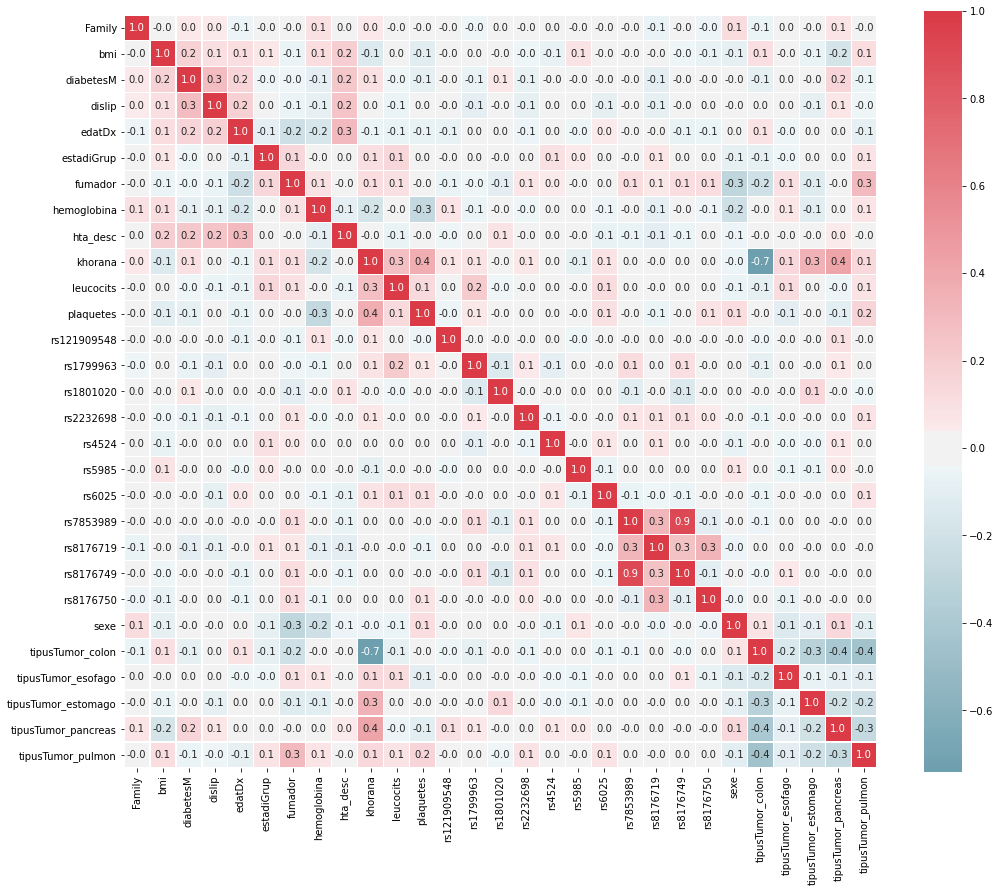

In [133]:
corr_heatmap(X, figsize=(15,15))

In [10]:
# check outliers
# import seaborn as sns

# sns.boxplot(X['hemoglobina'])

In [12]:
from sklearn.model_selection import train_test_split

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=1621)
print(X_train.shape, X_test.shape)

(298, 27) (100, 27)


In [11]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

### Baseline model (Logistic Regression)

In [76]:
from utils import *

In [86]:
clf = Pipeline([('Scaler', MinMaxScaler()),('LR',LogisticRegression(max_iter=1000, solver='liblinear', class_weight={1:20}))])

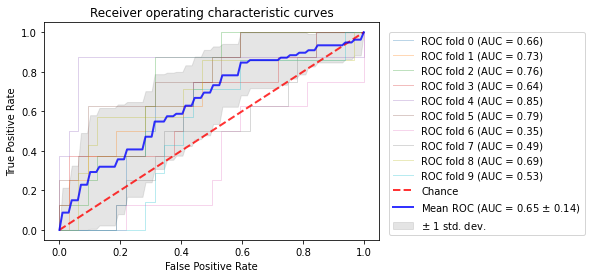

In [87]:
test_model(clf, X.to_numpy(), y)

In [43]:
SEED = 1135
class_weight = {1:1}

base_models = [
          ('LR', LogisticRegression(solver='liblinear', max_iter=1000, random_state=SEED)), 
          ('RF', RandomForestClassifier(random_state=SEED, class_weight=class_weight)),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier(class_weight=class_weight)),
          ('SVM', SVC(probability=True, random_state=SEED, class_weight=class_weight)), 
          ('AB', AdaBoostClassifier(random_state=SEED)),
          ('GBM', GradientBoostingClassifier(random_state=SEED)),
          ('ET', ExtraTreesClassifier(random_state=SEED, class_weight=class_weight)),
          ('LGB', LGBMClassifier(class_weight=class_weight, random_state=SEED)),
#           ('XGB', XGBClassifier(random_state=SEED))
        ]

In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler_name = 'standard'
  
if scaler_name == 'standard':
    scaler = StandardScaler()
elif scaler_name =='minmax':
    scaler = MinMaxScaler()

pipelines = []
for name, model in base_models:
  pipelines.append((name  , Pipeline([('Scaler', scaler),(name,model)])))

In [119]:
final = run_exps(pipelines, X, y)
bootstrap_df, results = results_bootstrap(final)

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predic

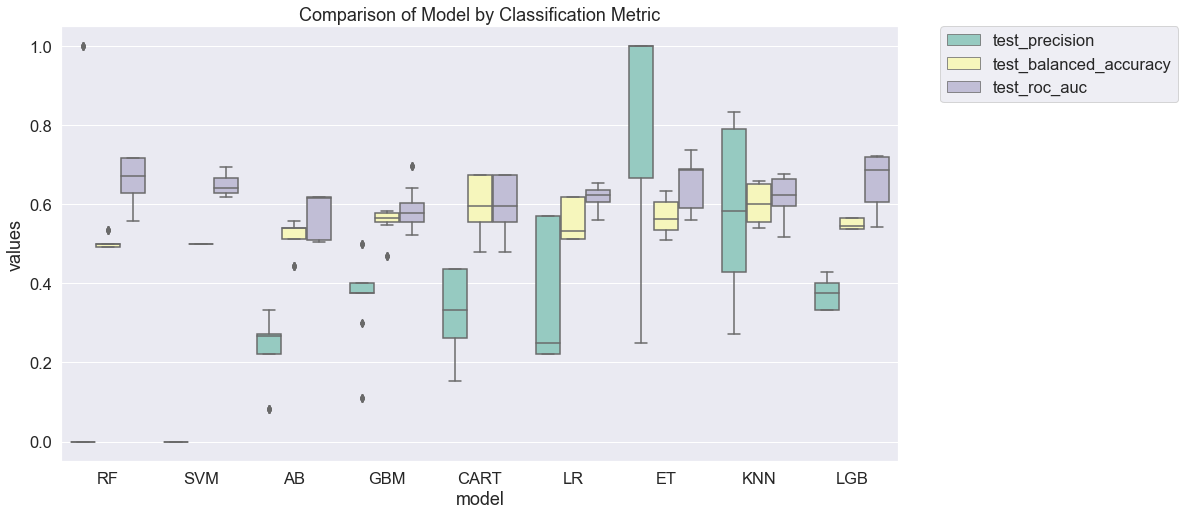

In [120]:
plot_performances(results)

In [121]:
tabulate_results(bootstrap_df, results)

test_balanced_accuracy           test_precision           test_roc_auc  \
                        mean       std           mean       std         mean   
model                                                                          
AB                  0.518665  0.042443       0.236556  0.089662     0.575350   
CART                0.582766  0.072244       0.303384  0.105753     0.582766   
ET                  0.575439  0.042187       0.808333  0.268979     0.660534   
GBM                 0.550982  0.037742       0.355778  0.120363     0.590934   
KNN                 0.600779  0.044962       0.585108  0.190410     0.614655   
LGB                 0.549620  0.013071       0.367071  0.036661     0.658516   
LR                  0.551889  0.043140       0.343333  0.148483     0.621661   
RF                  0.504810  0.016017       0.200000  0.404061     0.656531   
SVM                 0.500000  0.000000       0.000000  0.000000     0.650538   

                 
            std  
model            
AB     0.054793  
CART   0.072244  
ET     0.062936  
GBM    0.058220  
KNN    0.056598  
LGB    0.065479  
LR     0.029101  
RF     0.058386  
SVM    0.028155

In [43]:
clf = Pipeline([('Scaler', MinMaxScaler()),('LR',LogisticRegression())])
clf.fit(X_train, y_train)

Pipeline(steps=[('Scaler', MinMaxScaler()), ('LR', LogisticRegression())])

AUC score (train): 0.7716
AUC score (test): 0.7331


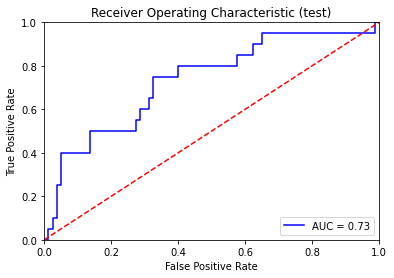


Accuracy in train set (%): 80.2
Accuracy in test set (%): 80.0

=====Train set=====
[[236   4]
 [ 55   3]]

Sensivity (%): 5.17
Specificity (%): 98.33
Precision (%): 42.86
NPV (%): 81.10000000000001

=====Test set=====
[[78  2]
 [18  2]]

Sensivity (%): 10.0
Specificity (%): 97.5
Precision (%): 50.0
NPV (%): 81.25


In [44]:
y_pred_train = clf.predict_proba(X_train)[:,1]
y_pred_test = clf.predict_proba(X_test)[:,1]

evaluate_model(y_train, y_pred_train, y_test, y_pred_test)

AUC score (train): 0.9821
AUC score (test): 0.6862


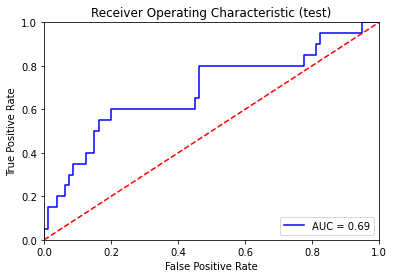


Accuracy in train set (%): 80.54
Accuracy in test set (%): 80.0

=====Train set=====
[[240   0]
 [ 58   0]]

Sensivity (%): 0.0
Specificity (%): 100.0
Precision (%): nan
NPV (%): 80.54

=====Test set=====
[[80  0]
 [20  0]]

Sensivity (%): 0.0
Specificity (%): 100.0
Precision (%): nan
NPV (%): 80.0


D:\pablo\master\TFM\utils.py:481: RuntimeWarning: invalid value encountered in longlong_scalars
  PPV = tp / (tp+fp)


In [45]:
clf = Pipeline([('Scaler', StandardScaler()),('SVM',SVC(probability=True))])
clf.fit(X_train, y_train)

y_pred_train = clf.predict_proba(X_train)[:,1]
y_pred_test = clf.predict_proba(X_test)[:,1]

evaluate_model(y_train, y_pred_train, y_test, y_pred_test)

AUC score (train): 1.0
AUC score (test): 0.6404


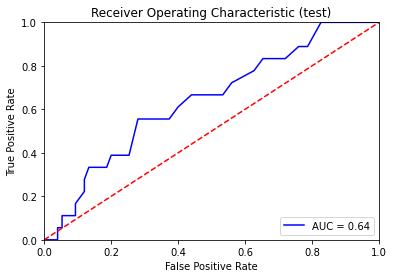


Accuracy in train set (%): 82.25
Accuracy in test set (%): 72.04

=====Train set=====
[[174  49]
 [  0  53]]

Sensivity (%): 100.0
Specificity (%): 78.03
Precision (%): 51.959999999999994
NPV (%): 100.0

=====Test set=====
[[60 15]
 [11  7]]

Sensivity (%): 38.89
Specificity (%): 80.0
Precision (%): 31.819999999999997
NPV (%): 84.50999999999999


In [58]:
clf = Pipeline([('Scaler', StandardScaler()),('RF', RandomForestClassifier())])
clf.fit(X_train, y_train)

y_pred_train = clf.predict_proba(X_train)[:,1]
y_pred_test = clf.predict_proba(X_test)[:,1]

evaluate_model(y_train, y_pred_train, y_test, y_pred_test)